# Problema 2:
Considere el entramado mostrado en la figura, con una fuerza aplicada de 20 kN. Calcule los desplazamientos de cada uno de los nodos y las tensiones que sufre cada elemento. Todos los elementos tienen E = 210 GPa y una sección de 10 cm2, excepto el elemento 3, que tiene una sección de 20 cm2. Los elementos 2 y 5 tienen una longitud de 8 metros y el elemento 3 de 4 metros.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def loc_a_glob (z):
    c=np.cos(z)
    s=np.sin(z)
    K=[[ c**2,    c*s ,   -c**2, -c*s] , 
       [ c*s,      s**2,   -c*s, -s**2] , 
       [-c**2,    -c*s,    c**2,  c*s], 
       [-c*s,     -s**2,    c*s,   s**2]]
    return np.array(K)

(array([     0.,  10000.,      0.,      0.,      0.,  10000.,      0.,
        -20000.]),
 array([ 0.        ,  0.        ,  0.0007619 , -0.0036534 ,  0.00152381,
         0.        ,  0.0007619 , -0.00384387]),
 array([[ 20000000.,  10000000., -20000000., -10000000.],
        [ 20000000.,         0., -20000000.,         0.],
        [        0., -10000000.,         0.,  10000000.],
        [ 20000000., -10000000., -20000000.,  10000000.],
        [ 20000000.,         0., -20000000.,         0.]]),
 array([[ 4.50329710e+07,  9.39148551e+06, -1.87829710e+07,
         -9.39148551e+06,  0.00000000e+00,  0.00000000e+00,
         -2.62500000e+07,  0.00000000e+00],
        [ 9.39148551e+06,  4.69574275e+06, -9.39148551e+06,
         -4.69574275e+06,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-1.87829710e+07, -9.39148551e+06,  3.75659420e+07,
         -5.58793545e-09, -1.87829710e+07,  9.39148551e+06,
         -3.93686943e-25,  6.42939570e-09],
    

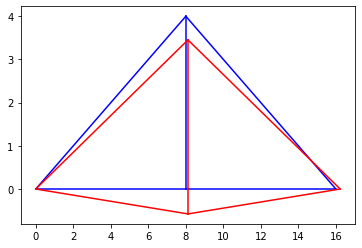

In [126]:
N = 4                      # cantidad de nodos = cantidad de elementos -1
E = np.ones(N+1)*210e9           # Módulo elástico de cada elemento GPa
A = np.ones(N+1)*10e-4          # Area de cada elementos cm2
A[2] = 20e-4
GL = 2                               # Grados de libertad

MN = [[0,0] , [8,4], [16,0] , [8,0]]  # MAtriz de nodos (posiciones de los nodos) (ejercicio)

MC = [[0,1] , [3,0] , [3,1] , [1,2] , [2,3]]      # Matriz de conectividad de elementos (el  elemento 0: entre nodo 0: MN[0] y nodo 1 MN[1])  ) (ejercicio)

CC = [[2,0] , [2,0] , [1,0] , [1,0] , [1,0] ,  [2,0] ,  [1,0] ,  [1,-20000]] # [ (1: F o 2: u)  , valor conocido]

def DifFin(MN, MC, CC, E, A, graf=True):
    
    N=len(MN)
    GL=len(MN[0])
    K = np.zeros([N*GL,N*GL])     # Matriz rigidez GLOBAL kN/m
    R_locales=[]
    for i in range(len(MC)):
        dx= MN[MC[i][0]][0] - MN[MC[i][1]][0]
        dy = MN[MC[i][0]][1] - MN[MC[i][1]][1]
        dL=np.sqrt( dx ** 2 + dy ** 2 )
        k=E[i]*A[i]/dL    
        z=np.arctan2(dy,dx)         
        R=k*loc_a_glob(z)  # Matriz de rigidez local rotada
        R_locales.append(R)
        for j in MC[i]:
            for l in MC[i]:    
                n1=j*GL
                n2=l*GL
                p=MC[i].index(j)*GL
                t=MC[i].index(l)*GL
                K[n1:n1+GL,n2:n2+GL]+=R[p:p+GL,t:t+GL]


    #indices de Fuerzas y desplazamientos conocidxs:
    u = np.zeros(N*GL)
    fc=[]
    uc=[]
    for i in range(len(CC)):
        if CC[i][0]==1:
            fc.append([i,CC[i][1]])
        else: 
            uc.append([i,CC[i][1]])
            u[i]=CC[i][1]

    fc=np.array(fc)
    uc=np.array(uc)

    uu = np.linalg.solve(K[np.ix_(fc[:,0], fc[:,0])], fc[:,1]-K[np.ix_(fc[:,0], uc[0,:])].dot(uc[0,:]))

    for i in range(len(fc)):
        u[fc[i,0]]=uu[i]


    F=K.dot(u)
    F[np.abs(F) < 1e-8 ]  = 0
    u[np.abs(u) < 1e-8 ]  = 0
    
    T=[]
    for i in range(len(MC)):
        p,j = MC[i]
        T.append( np.dot(R_locales[i],np.concatenate([u[GL*p:GL*p+2], u[GL*j:GL*j+2]])) /A[i] )     #Tensiones
    T=np.array(T)
    T[np.abs(T) < 1e-8 ]  = 0
    T=np.round(T, 3)
    
    # Gráfico
    if graf==True:
        for i in MC:    
            plt.plot([MN[i[0]][0], MN[i[1]][0]], [MN[i[0]][1], MN[i[1]][1]], "b")

        MNf=copy.copy(MN) # MN final
        for i in range(len(MN)):  
            MNf[i][0]+=150*u[i*2]
            MNf[i][1]+=150*u[i*2+1]

        for i in MC:    
            plt.plot([MNf[i[0]][0], MNf[i[1]][0]], [MNf[i[0]][1], MNf[i[1]][1]], "r")
    
    return F, u, T, K

DifFin(MN, MC, CC, E, A)

# Confirmación de suma de rigidez local en la global:

x=np.array([[1,1,1,1], [2,2,2,2],[3,3,3,3],[4,4,4,4]])
y=np.array([[5,5,5,5], [6,6,6,6],[7,7,7,7],[8,8,8,8]])
z=np.array([[9,9,9,9], [10,10,10,10],[12,12,26,26],[13,13,25,25]])

K = np.zeros([6,6])  
e=[x,y,z]
MC=[[0,1],[1,2],[2,0]]
for i in range(len(MC)): 
    K0=copy.copy(K)
    n1=MC[i][0]*2
    n2=MC[i][1]*2
    if i==0:
        kLoc=x
    elif i==1:
        kLoc=y
    else:
        kLoc=z
    K[n1:n1+2,n1:n1+2]+=kLoc[0:2,0:2]
    K[n1:n1+2,n2:n2+2]+=kLoc[0:2,2:4]
    K[n2:n2+2,n1:n1+2]+=kLoc[2:4,0:2]
    K[n2:n2+2,n2:n2+2]+=kLoc[2:4,2:4]
    print(K-K0)

In [114]:
np.array([1,3,4,5])*2

array([ 2,  6,  8, 10])